In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
# paths
DIR = ("C:/Users/aditi/Downloads/Post-hurricane")
train_path = os.path.join(DIR, "C:/Users/aditi/Downloads/Post-hurricane/train_another")
val_path = os.path.join(DIR, "C:/Users/aditi/Downloads/Post-hurricane/validation_another")
test_path = os.path.join(DIR, "C:/Users/aditi/Downloads/Post-hurricane/test")

In [3]:
'''
Load Training/Validation/Test Data
Simple Loading
First I load the training and validation sets as-is with no image augmentation. I'll use this for the first baseline model.
'''
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
'''
Loading with Image Augmentation
Below I leverage the keras ImageDataGenerator to add an image augmentation pipeline. AS the training dataset is rather small (10,000 images), this will create more variation in the training dataset to reduce model overfitting and improve performance.

I limited image augmentation to a few types that are similar to the kinds of variation that might be caused by differences between instances of structures, as well as differences due to the how imagery aircraft fly.

Note that we do not do any image augmentation for the validation data.
'''
image_size = (128, 128)
batch_size = 100

# TRAINING
# specify training image transformations 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# keras generator for training data
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')


# VALIDATION
# specify validation image transformations (rescale only)
val_datagen = ImageDataGenerator(rescale=1./255)

# keras generator for validation data
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
def plot_nn_training(history):
    
    '''Given model training history, plots validation accuracy and loss'''
    
    # plot history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # plot history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [9]:
def generate_model3_lr(input_shape, num_classes):
    
    '''CNN model architecture with max pooling + dropout layers'''
    
    inputs = Input(shape=input_shape)
    
    #x = Rescaling(1.0 / 255)
    
    # convolution (with max pooling)
    x = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    #flatten
    x = Flatten()(x)
    
    #dense layers (with dropout to avoid overfitting)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # output layer
    output = Dense(2, activation='softmax')(x)
    
    mod = Model(inputs=inputs, outputs=output)
    
    return mod

epochs = 100

#Adds adam optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                decay=0.0,
                                amsgrad=False)

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model3/best_model_test.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
model3_lr = generate_model3_lr(input_shape=(128,128,3), num_classes=2)

# Compile model
model3_lr.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [10]:
# train model
results3_lr = model3_lr.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    verbose=4,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50


C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/Model3/best_model_test.keras
Epoch 2/50


C:\Users\aditi\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/50


C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)



Epoch 3: val_accuracy did not improve from 0.50000
Epoch 4/50
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.50000
Epoch 6/50
Epoch 7/50

Epoch 7: val_accuracy improved from 0.50000 to 0.50150, saving model to models/Model3/best_model_test.keras
Epoch 8/50
Epoch 9/50

Epoch 9: val_accuracy improved from 0.50150 to 0.53050, saving model to models/Model3/best_model_test.keras
Epoch 10/50
Epoch 11/50

Epoch 11: val_accuracy improved from 0.53050 to 0.79450, saving model to models/Model3/best_model_test.keras
Epoch 12/50
Epoch 13/50

Epoch 13: val_accuracy improved from 0.79450 to 0.96350, saving model to models/Model3/best_model_test.keras
Epoch 14/50
Epoch 15/50

Epoch 15: val_accuracy did not improve from 0.96350
Epoch 16/50
Epoch 17/50

Epoch 17: val_accuracy did not improve from 0.96350
Epoch 18/50
Epoch 19/50

Epoch 19: val_accuracy did not improve from 0.96350
Epoch 20/50
Epoch 21/50

Epoch 21: val_accuracy did not improve from 0.96350
Epoch 22/50
Epoch 23/50

Epoch 23: v

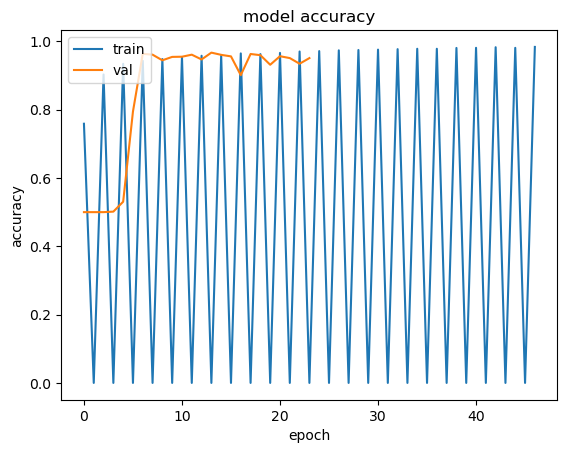

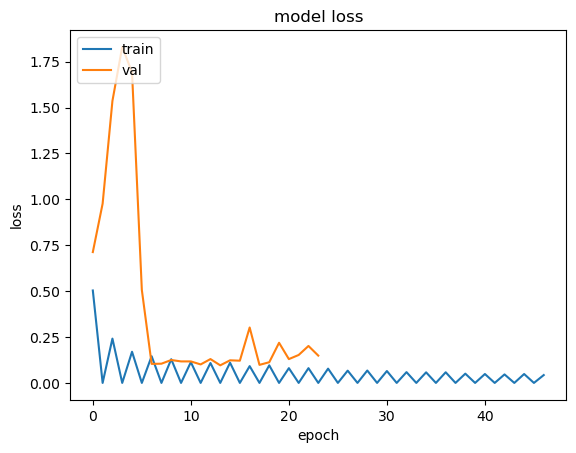

In [11]:
plot_nn_training(results3_lr)